# Network Architecture Design

This notebook is heavily based on [this](https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439) wonderful, detailed tutorial of Faster-RCNN implementation.

### Contents
- [Get feature-extractor from pre-trained Resnet34](#Get-feature-extractor-from-pre-trained-Resnet34): load a pre-trained Resnet and use its first layers as a feature-extractor with cell-size corresponding to the typical object size in the data.
- [Anchor boxes](#Anchor-boxes): define anchor boxes according to the typical object size in the data (displayed at the bottom of the notebook).
- [Receptive field](#Receptive-field-analysis): analyze receptive fields (displayed at the bottom of the notebook) and make sure they suit the typical range of objects' informative environment in the data.
define and display anchor boxes and receptive fields according to the typical object size in the data.
- [Labels assignment](#Labels-assignment): define labels of anchor boxes for training (does the anchor box contain an object + object location within the box).
- [Region Proposal Network (RPN)](#Region-Proposal-Network): define classification (for detection) and regression (for location) layers on top of the feature-map.
- **[Summary](#Summary): summarizing figures and visualizations.**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict
import cv2
from PIL import Image

In [3]:
import torch as t
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision as tv

In [4]:
mpl.rcParams.update({'font.size': 14})
CMAP = plt.get_cmap('rainbow')

In [5]:
IMAGES_PATH = Path(r'../annotator/sampled_frames')
ANNOTATIONS = Path(r'../annotator/annotation_data/annotations.pkl')
OUT_LABELS = 'labels/anchor_labels.pkl'

In [6]:
data = pd.read_pickle(ANNOTATIONS)
files = list(np.unique(data.file))
image = Image.open(IMAGES_PATH/files[0])

_______________

## Get feature-extractor from pre-trained Resnet34

In [7]:
W,H = image.size
W,H

(1920, 1080)

In [8]:
model = tv.models.resnet34(pretrained=True)

In [9]:
len(list(model.named_children()))

10

In [10]:
X = t.tensor(np.array(image))
print(X.shape)
X = X.unsqueeze(0)
print(X.shape)
X = X.permute(0,1,2,3)
print(X.shape)
X = X.permute(0,3,1,2)
print(X.shape)
# should be NCHW
X = X.type('torch.FloatTensor')
X = Variable(t.Tensor(X))
# layer(X).shape

torch.Size([1080, 1920, 3])
torch.Size([1, 1080, 1920, 3])
torch.Size([1, 1080, 1920, 3])
torch.Size([1, 3, 1080, 1920])


In [11]:
layers = model.children()
tmp = X
print(tmp.shape)
for i,layer in enumerate(layers):
    print(i,layer)
    tmp = layer(tmp)
    print(tmp.shape)
    if tmp.shape[2]<=1 or tmp.shape[3]<=1:
        break

torch.Size([1, 3, 1080, 1920])
0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
torch.Size([1, 64, 540, 960])
1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([1, 64, 540, 960])
2 ReLU(inplace)
torch.Size([1, 64, 540, 960])
3 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
torch.Size([1, 64, 270, 480])
4 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

Desired size (1080x1920)/8 = 135x240 was achieved after layer number 5 (and happened to be exact). Thus:

In [12]:
conv = nn.Sequential(*list(model.children())[:6])
for param in model.parameters():
    param.requires_grad = False
conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [13]:
features = conv(X)

In [14]:
map_h,map_w = features.shape[-2:]
features.shape

torch.Size([1, 128, 135, 240])

In [15]:
feature_size = image.size[0] // features.shape[-1]
feature_size

8

_______________

## Anchor boxes

Change boxes format to y1,x1,y2,x2:

In [16]:
data['y1'] = data['y']
data['x1'] = data['x']
data['y2'] = data['y'] + data['dy']
data['x2'] = data['x'] + data['dx']

In [17]:
anchor_scales = (3, 6, 12)
anchor_ratios = (0.5, 1, 2)

In [18]:
box_y0 = feature_size * np.arange(map_h) + feature_size/2
box_x0 = feature_size * np.arange(map_w) + feature_size/2
box_center = [(y0,x0) for y0 in box_y0 for x0 in box_x0]

anchors = np.zeros((map_h * map_w * len(anchor_ratios) * len(anchor_scales), 4))
print(anchors.shape)

index = 0
for y0,x0 in tqdm_notebook(box_center):
    for i,ratio in enumerate(anchor_ratios):
        for j,scale in enumerate(anchor_scales):
            h = feature_size * scale * np.sqrt(ratio)
            w = feature_size * scale * np.sqrt(1./ratio)
            anchors[index, 0] = y0 - h / 2.
            anchors[index, 1] = x0 - w / 2.
            anchors[index, 2] = y0 + h / 2.
            anchors[index, 3] = x0 + w / 2.
            index += 1

(291600, 4)


In [19]:
valid_anchor_ids = np.where((anchors[:,0]>=0) & (anchors[:,2]<=H) & (anchors[:,1]>=0) & (anchors[:,3]<=W))[0]
valid_anchors = anchors[valid_anchor_ids, :]
len(valid_anchors)

268870

In [20]:
# anchors locations for later labeling
base_h = valid_anchors[:, 2] - valid_anchors[:, 0]
base_w = valid_anchors[:, 3] - valid_anchors[:, 1]
base_y0 = valid_anchors[:, 0] + 0.5 * base_h
base_x0 = valid_anchors[:, 1] + 0.5 * base_w

# force positive size
eps = np.finfo(base_h.dtype).eps
base_h = np.maximum(base_h, eps)
base_w = np.maximum(base_w, eps)

_______________

## Receptive field analysis

- **Every cell in a feature map stands for `nxn` pixels** in the original input (with `n` increasing, for example, in pooling-layers and in conv-layers with strides).
- **Every conv-layer with kernel `kxk`** increases the receptive radius ("radius" here means half-edge of a square...) by `((k-1)/2) * n`.
- Similarly, **grouping kxk cells into an anchor box** increases their shared receptive radius by `((k-1)/2) * n`.
- The **receptive radius `R`** of a cell in a feature map is the sum of increases over the layers.
- The **receptive field** of a cell usually refers to a square of size rxr around the cell, with `r = 1 + 2*R`.

In our case:
- The first conv layer with kernel 7x7 increases the receptive radius by `3`.
- The next sequence of 6 layers with kernels 3x3 increases the radius by `(6 layers * 1 * 4) = 24`.
- The next sequence of 8 layers with kernels 3x3 increases the radius by `(8 layers * 1 * 8) = 64`.
- The smallest anchor boxes consist of 3x3 cells (TODO understand how it works with ratio!=1...), increasing the radius by `8`.

Hence, **the receptive field of the smallest anchor boxes is of size `r = 1 + 2*(3+24+64+8) = 199`.
We can see (far) below that this is a very reasonable range considering the distances in the images.**


_____________________

TODO in addition to the feature map, add the anchor box location to the NN. also consider using GBM on top of the feature map?

_______________

## Labels assignment

In [21]:
n_images = len(files)

Assign target labels to anchor boxes:

In [22]:
data.head()

,file,x,y,dx,dy,y1,x1,y2,x2,size,x_group
0,20190520_105429_1080.png,411.896,619.069,36.776,20.840,619.069,411.896,639.909,448.672,27.684144,"(-0.001, 668.769]"
1,20190520_105429_1080.png,197.367,608.036,57.616,42.906,608.036,197.367,650.942,254.983,49.719937,"(-0.001, 668.769]"
2,20190520_105429_1080.png,89.489,620.295,71.101,36.777,620.295,89.489,657.072,160.590,51.135912,"(-0.001, 668.769]"
3,20190520_105429_1080.png,85.812,655.846,46.583,18.388,655.846,85.812,674.234,132.395,29.267186,"(-0.001, 668.769]"
4,20190520_105429_1080.png,51.487,673.008,58.842,22.066,673.008,51.487,695.074,110.329,36.033423,"(-0.001, 668.769]"


In [23]:
boxes = data.groupby('file').apply(
    lambda d: np.asarray([list(d.iloc[i,5:9]) for i in range(len(d))], dtype=np.float32))

In [24]:
# Note: ious could be computed more efficiently using concepts of spatial search:
#       we don't need to compare every object to every anchor, but only to anchors in its surrounding.

# Source: https://medium.com/@venuktan/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow-4fa16231b63d

def get_ious(boxes1, boxes2, return_A_contains_B=False):
    y11, x11, y12, x12 = np.split(boxes1, 4, axis=1)
    y21, x21, y22, x22 = np.split(boxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    if return_A_contains_B:
        return (interArea == np.transpose(boxBArea))
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [25]:
%time ious = [get_ious(valid_anchors, boxes_i) for boxes_i in boxes]
%time containing = [get_ious(valid_anchors, boxes_i, return_A_contains_B=True) for boxes_i in boxes]

Wall time: 14.3 s
Wall time: 11.9 s


In [26]:
ious[0].shape

(268870, 67)

In [27]:
valid_labels = np.empty((len(valid_anchors),n_images), dtype=np.int32)
valid_labels.fill(-1) # -1 means neither full object nor empty - so don't use to train
locations = np.empty((valid_anchors.shape[0], valid_anchors.shape[1], n_images), dtype=np.float64)
locations.fill(0)


for i in tnrange(len(np.unique(data['file']))):
    
    # find best anchor for each actual object
    best_anchor_per_obj = ious[i].argmax(axis=0)
    #print(best_anchor_per_obj.shape)
    best_iou_per_obj = ious[i][best_anchor_per_obj, np.arange(ious[i].shape[1])]
    #print(best_iou_per_obj.shape)

    # multiple anchors may be best for a single obj
    #best_anchors_per_obj = np.concatenate([np.where(ious[i][:,j]==best_iou_per_obj[j])[0]
    #                                       for j in range(len(best_anchor_per_obj))])
    best_anchors_per_obj, obj_associated_with_best_anchor = np.where(ious[i]==best_iou_per_obj)
    #print(best_anchors_per_obj.shape)
    
    # find best iou for each anchor
    best_obj_per_anchor = ious[i].argmax(axis=1)
    best_iou_per_anchor = ious[i][np.arange(len(valid_anchors)), best_obj_per_anchor]
    anchor_containing_any_obj = np.any(containing[i], axis=1)
    #print(best_iou_per_anchor.shape)
    
    # best_obj_per_anchor, i.e. obj with highest iou, ins't necessarily "best" - best may be a small object (thus small iou compared to other objs) which is fully contained in anchor (thus large iou compared to other anchors).
    # fix it.
    suspicious_anchors = best_anchors_per_obj[obj_associated_with_best_anchor != best_obj_per_anchor[best_anchors_per_obj]]
    bad_anchors = suspicious_anchors[[
        ( sa not in best_anchors_per_obj[ np.where(obj_associated_with_best_anchor == best_obj_per_anchor[sa])[0] ] )
        and (ious[i][sa, best_obj_per_anchor[sa]] < 0.7)
        for sa in suspicious_anchors
    ]]
    for ba in bad_anchors:
        best_obj_per_anchor[ba] = obj_associated_with_best_anchor[best_anchors_per_obj==ba][0]
    
    # set labels
    valid_labels[np.logical_and(best_iou_per_anchor<0.3,np.logical_not(anchor_containing_any_obj)), i] = 0 # no-object target
    # Note: rule for background (no-object) was modified such that small objects (<30% of anchor)
    #       won't be considered "background" if fully contained in anchor.
    valid_labels[best_iou_per_anchor >= 0.7, i] = 1 # object target
    valid_labels[best_anchors_per_obj, i] = 1       # object target
    
    # best objs locations
    obj_h = boxes[i][best_obj_per_anchor, 2] - boxes[i][best_obj_per_anchor, 0]
    obj_w = boxes[i][best_obj_per_anchor, 3] - boxes[i][best_obj_per_anchor, 1]
    obj_y0 = boxes[i][best_obj_per_anchor, 0] + 0.5 * obj_h
    obj_x0 = boxes[i][best_obj_per_anchor, 1] + 0.5 * obj_w

    # relative locations within anchors
    dy = (obj_y0 - base_y0) / base_h
    dx = (obj_x0 - base_x0) / base_w
    dh = np.log(obj_h / base_h)
    dw = np.log(obj_w / base_w)
    locations[:,:,i] = np.vstack((dy, dx, dh, dw)).transpose()
    
    # look at objects larger than their anchor box (for display)
    if i==0:
        largest_rel_width = np.max(dw[valid_labels[:,0]==1])
        largest_rel_width_i = np.where( np.logical_and((dw==largest_rel_width), (valid_labels[:,0]==1)) )[0][0]
        largest_rel_width = np.exp(largest_rel_width)


print(locations.shape)
print(valid_labels.shape)
Counter(valid_labels.flatten())


(268870, 4, 10)
(268870, 10)


Counter({0: 2667600, 1: 1078, -1: 20022})

In [28]:
# project onto all anchors (including invalid ones that get out of the margins)

anchor_labels = np.empty((len(anchors), n_images), dtype=valid_labels.dtype)
anchor_labels.fill(-1)
anchor_labels[valid_anchor_ids, :] = valid_labels

anchor_locations = np.empty((anchors.shape[0], anchors.shape[1], n_images), dtype=locations.dtype)
anchor_locations.fill(0)
anchor_locations[valid_anchor_ids, :, :] = locations

print(anchor_labels.shape, anchor_locations.shape)
Counter(anchor_labels.flatten())

(291600, 10) (291600, 4, 10)


Counter({-1: 247322, 0: 2667600, 1: 1078})

In [29]:
# save output labels
pkl.dump({'anchor_labels':anchor_labels, 'anchor_target_locations':anchor_locations, 'anchor_boxes_locations':anchors},
         open(OUT_LABELS,'wb'))

Note: when training with batch_size, each batch will be taken from a single image, and will sample `n_pos=min(n_objs,batch_size/2)` anchors with value +1 and `batch_size-n_pos` anchors with value 0.

________________________

## Region Proposal Network

Define RPN layers on top of the feature map: conv layer + (cls_layer for object detection and reg_layer for location).

In [30]:
in_channels = features.shape[1] # 128
mid_channels = 2 * features.shape[1] # 256
n_anchor = 9 # Number of anchors at each location

conv_layer = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
reg_layer = nn.Conv2d(mid_channels, 4*n_anchor,   1, 1, 0)
cls_layer = nn.Conv2d(mid_channels, 1*n_anchor,   1, 1, 0)

In [31]:
# Initialize layers weights (according to paper's suggestion)

conv_layer.weight.data.normal_(0, 0.01)
conv_layer.bias.data.zero_()

reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_();

In [32]:
mid = conv_layer(features)
rel_loc_preds = reg_layer(mid)
scores_preds = cls_layer(mid)

print('For a single image - shapes of features, mid-layer, locations and scores:',
      features.shape, mid.shape, rel_loc_preds.shape, scores_preds.shape, sep='\n')

For a single image - shapes of features, mid-layer, locations and scores:
torch.Size([1, 128, 135, 240])
torch.Size([1, 256, 135, 240])
torch.Size([1, 36, 135, 240])
torch.Size([1, 9, 135, 240])


_______________

## Summary

### Labels & locations analysis

Counter({-1: 247322, 0: 2667600, 1: 1078})

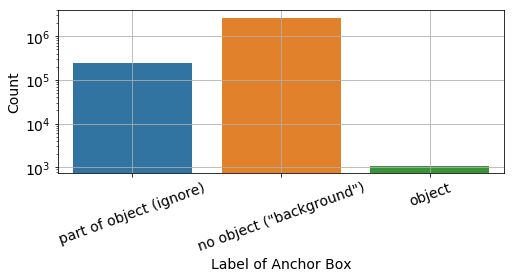

In [33]:
labs_dist = Counter(anchor_labels.flatten())

plt.figure(figsize=(8,3))
sns.barplot(x=list(labs_dist.keys()), y=list(labs_dist.values()))
plt.xticks((0,1,2), ('part of object (ignore)','no object ("background")','object'), rotation=20)
plt.yscale('log')
plt.xlabel('Label of Anchor Box')
plt.ylabel('Count')
plt.grid()

labs_dist

Larger height than anchor box:	16.9%
Larger width than anchor box:	14.9%


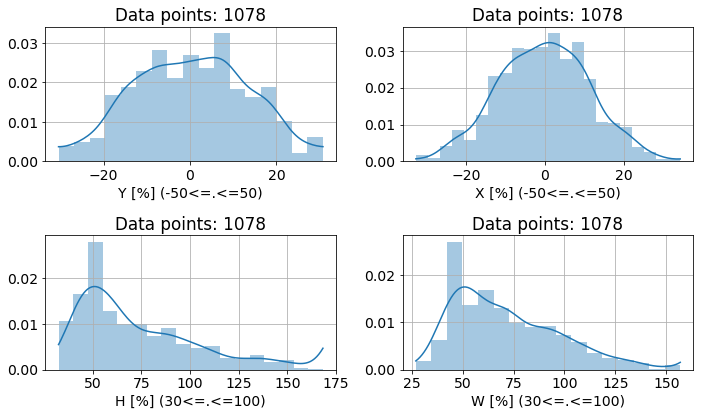

In [34]:
_, axs = plt.subplots(2,2, figsize=(10,6))

for c in range(4):
    ax = axs[c//2, c%2]
    #sns.distplot(anchor_locations[:,i,:].flatten(), ax=ax)
    tmp = [100*el if c<2 else 100*np.exp(el)
           for lst in [anchor_locations[np.where(anchor_labels[:,i]==1)[0],c,i] for i in range(anchor_locations.shape[2])]
           for el in lst] # only locations of actual objs (label==1)
    if c>=2:
        print(f'Larger {("height","width")[c-2]:s} than anchor box:\t{100*(np.array(tmp)>100).mean():.1f}%')
    sns.distplot(tmp, kde_kws={'cut':0}, ax=ax)
    ax.set_xlabel(('Y [%] (-50<=.<=50)','X [%] (-50<=.<=50)','H [%] (30<=.<=100)','W [%] (30<=.<=100)')[c])
    ax.set_title(f'Data points: {len(tmp):d}')
    ax.grid()
    
plt.tight_layout()

### Summarizing visualization

In [35]:
# repeat objects location calculation for first image for display purposes
best_anchor_per_obj = ious[0].argmax(axis=0)
best_iou_per_obj = ious[0][best_anchor_per_obj, np.arange(ious[0].shape[1])]

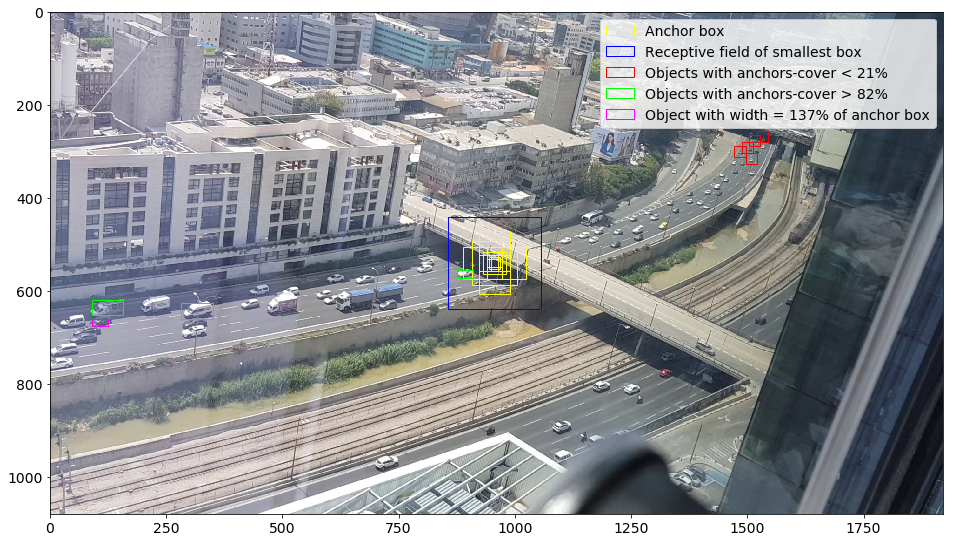

In [36]:
plt.figure(figsize=(16,10))

plt.imshow(image)

ax = plt.gca()
for i in range(anchors.shape[0]//2-9, anchors.shape[0]//2):
    ax.add_patch(mpl.patches.Rectangle((anchors[i,1],anchors[i,0]), (anchors[i,3]-anchors[i,1]), (anchors[i,2]-anchors[i,0]),
                                       color='yellow', fill=False, label='Anchor box' if i==anchors.shape[0]//2-9 else None))

# Receptive field
ax.add_patch(mpl.patches.Rectangle(((anchors[i,3]+anchors[i,1])/2-99, (anchors[i,2]+anchors[i,0])/2-99), 199, 199,
                                   color='blue', fill=False, label='Receptive field of smallest box'))

# Objects with worst/best covers by anchors (calculated below)
bad_covers = valid_anchors[best_anchor_per_obj[np.argsort(best_iou_per_obj)[:5]]]
max_bad_cover = np.sort(best_iou_per_obj)[4]
for cover in bad_covers:
    ax.add_patch(mpl.patches.Rectangle((cover[1],cover[0]), (cover[3]-cover[1]), (cover[2]-cover[0]),
                                       color='red', fill=False,
                                       label=f'Objects with anchors-cover < {100*max_bad_cover:.0f}%' if (cover==bad_covers[0]).all() else None))
good_covers = valid_anchors[best_anchor_per_obj[np.argsort(best_iou_per_obj)[-3:]]]
min_good_cover = np.sort(best_iou_per_obj)[-3]
for cover in good_covers:
    ax.add_patch(mpl.patches.Rectangle((cover[1],cover[0]), (cover[3]-cover[1]), (cover[2]-cover[0]),
                                       color='lime', fill=False,
                                       label=f'Objects with anchors-cover > {100*min_good_cover:.0f}%' if (cover==good_covers[0]).all() else None))
cover = valid_anchors[largest_rel_width_i]
ax.add_patch(mpl.patches.Rectangle((cover[1],cover[0]), (cover[3]-cover[1]), (cover[2]-cover[0]),
                                   color='magenta', fill=False,
                                   label=f'Object with width = {100*largest_rel_width:.0f}% of anchor box'))

ax.legend();